In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%204%20Lesson%201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.3.0


In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [4]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [5]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 30
train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 0s 12ms/step - loss: 73.1912 - mae: 73.6904
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 72.4799 - mae: 72.9791
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 71.3446 - mae: 71.8437
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 69.9230 - mae: 70.4223
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 68.2678 - mae: 68.7669
Epoch 6/100
8/8 [==============================] - 0s 8ms/step - loss: 66.3621 - mae: 66.8609
Epoch 7/100
8/8 [==============================] - 0s 8ms/step - loss: 64.2432 - mae: 64.7424
Epoch 8/100
8/8 [==============================] - 0s 8ms/step - loss: 61.8749 - mae: 62.3738
Epoch 9/100
8/8 [==============================] - 0s 9ms/step - loss: 59.2491 - mae: 59.7479
Epoch 10/100
8/8 [==============================] - 0s 9ms/step - loss: 56.3267 - mae: 56.8254
Epoch 11/100
8/8 [==============================] - 0s 8ms

8/8 [==============================] - 0s 8ms/step - loss: 17.7216 - mae: 18.2159
Epoch 89/100
8/8 [==============================] - 0s 8ms/step - loss: 15.2372 - mae: 15.7311
Epoch 90/100
8/8 [==============================] - 0s 9ms/step - loss: 12.7762 - mae: 13.2677
Epoch 91/100
8/8 [==============================] - 0s 9ms/step - loss: 25.7660 - mae: 26.2638
Epoch 92/100
8/8 [==============================] - 0s 9ms/step - loss: 22.0296 - mae: 22.5250
Epoch 93/100
8/8 [==============================] - 0s 8ms/step - loss: 20.1602 - mae: 20.6557
Epoch 94/100
8/8 [==============================] - 0s 8ms/step - loss: 14.3378 - mae: 14.8302
Epoch 95/100
8/8 [==============================] - 0s 8ms/step - loss: 13.3813 - mae: 13.8734
Epoch 96/100
8/8 [==============================] - 0s 8ms/step - loss: 21.6468 - mae: 22.1432
Epoch 97/100
8/8 [==============================] - 0s 8ms/step - loss: 16.4649 - mae: 16.9594
Epoch 98/100
8/8 [==============================] - 0s 8ms/step

(1e-08, 0.0001, 0.0, 30.0)

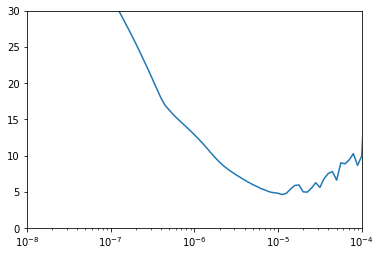

In [6]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
#batch_size = 16
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=500)

Epoch 1/500
31/31 [==============================] - 0s 6ms/step - loss: 20.0714 - mae: 20.5646
Epoch 2/500
31/31 [==============================] - 0s 5ms/step - loss: 7.9198 - mae: 8.4048
Epoch 3/500
31/31 [==============================] - 0s 6ms/step - loss: 6.6716 - mae: 7.1533
Epoch 4/500
31/31 [==============================] - 0s 5ms/step - loss: 6.1672 - mae: 6.6477
Epoch 5/500
31/31 [==============================] - 0s 5ms/step - loss: 5.7153 - mae: 6.1948
Epoch 6/500
31/31 [==============================] - 0s 6ms/step - loss: 5.6771 - mae: 6.1575
Epoch 7/500
31/31 [==============================] - 0s 5ms/step - loss: 5.4952 - mae: 5.9738
Epoch 8/500
31/31 [==============================] - 0s 6ms/step - loss: 5.3468 - mae: 5.8258
Epoch 9/500
31/31 [==============================] - 0s 6ms/step - loss: 5.2558 - mae: 5.7345
Epoch 10/500
31/31 [==============================] - 0s 5ms/step - loss: 5.2392 - mae: 5.7183
Epoch 11/500
31/31 [==============================] - 0s 

31/31 [==============================] - 0s 5ms/step - loss: 4.2956 - mae: 4.7712
Epoch 88/500
31/31 [==============================] - 0s 5ms/step - loss: 4.2212 - mae: 4.6954
Epoch 89/500
31/31 [==============================] - 0s 6ms/step - loss: 4.2227 - mae: 4.6974
Epoch 90/500
31/31 [==============================] - 0s 5ms/step - loss: 4.2339 - mae: 4.7083
Epoch 91/500
31/31 [==============================] - 0s 5ms/step - loss: 4.2417 - mae: 4.7159
Epoch 92/500
31/31 [==============================] - 0s 6ms/step - loss: 4.2415 - mae: 4.7166
Epoch 93/500
31/31 [==============================] - 0s 5ms/step - loss: 4.2153 - mae: 4.6895
Epoch 94/500
31/31 [==============================] - 0s 5ms/step - loss: 4.2899 - mae: 4.7639
Epoch 95/500
31/31 [==============================] - 0s 5ms/step - loss: 4.2715 - mae: 4.7464
Epoch 96/500
31/31 [==============================] - 0s 6ms/step - loss: 4.2326 - mae: 4.7076
Epoch 97/500
31/31 [==============================] - 0s 5ms/st

31/31 [==============================] - 0s 5ms/step - loss: 4.1387 - mae: 4.6124
Epoch 173/500
31/31 [==============================] - 0s 5ms/step - loss: 4.1098 - mae: 4.5831
Epoch 174/500
31/31 [==============================] - 0s 6ms/step - loss: 4.1119 - mae: 4.5854
Epoch 175/500
31/31 [==============================] - 0s 6ms/step - loss: 4.1493 - mae: 4.6240
Epoch 176/500
31/31 [==============================] - 0s 6ms/step - loss: 4.1082 - mae: 4.5807
Epoch 177/500
31/31 [==============================] - 0s 5ms/step - loss: 4.1105 - mae: 4.5838
Epoch 178/500
31/31 [==============================] - 0s 6ms/step - loss: 4.1315 - mae: 4.6058
Epoch 179/500
31/31 [==============================] - 0s 5ms/step - loss: 4.2801 - mae: 4.7556
Epoch 180/500
31/31 [==============================] - 0s 5ms/step - loss: 4.1045 - mae: 4.5771
Epoch 181/500
31/31 [==============================] - 0s 5ms/step - loss: 4.1244 - mae: 4.5984
Epoch 182/500
31/31 [==============================] -

31/31 [==============================] - 0s 6ms/step - loss: 4.1444 - mae: 4.6183
Epoch 258/500
31/31 [==============================] - 0s 6ms/step - loss: 4.0678 - mae: 4.5405
Epoch 259/500
31/31 [==============================] - 0s 6ms/step - loss: 4.0371 - mae: 4.5103
Epoch 260/500
31/31 [==============================] - 0s 5ms/step - loss: 4.0885 - mae: 4.5613
Epoch 261/500
31/31 [==============================] - 0s 5ms/step - loss: 4.1412 - mae: 4.6153
Epoch 262/500
31/31 [==============================] - 0s 5ms/step - loss: 4.0772 - mae: 4.5509
Epoch 263/500
31/31 [==============================] - 0s 5ms/step - loss: 4.0835 - mae: 4.5569
Epoch 264/500
31/31 [==============================] - 0s 5ms/step - loss: 4.0594 - mae: 4.5330
Epoch 265/500
31/31 [==============================] - 0s 6ms/step - loss: 4.0957 - mae: 4.5690
Epoch 266/500
31/31 [==============================] - 0s 5ms/step - loss: 4.0889 - mae: 4.5628
Epoch 267/500
31/31 [==============================] -

31/31 [==============================] - 0s 5ms/step - loss: 3.9968 - mae: 4.4689
Epoch 343/500
31/31 [==============================] - 0s 5ms/step - loss: 3.9940 - mae: 4.4667
Epoch 344/500
31/31 [==============================] - 0s 5ms/step - loss: 4.0085 - mae: 4.4815
Epoch 345/500
31/31 [==============================] - 0s 5ms/step - loss: 3.9983 - mae: 4.4711
Epoch 346/500
31/31 [==============================] - 0s 5ms/step - loss: 3.9740 - mae: 4.4458
Epoch 347/500
31/31 [==============================] - 0s 5ms/step - loss: 3.9932 - mae: 4.4652
Epoch 348/500
31/31 [==============================] - 0s 5ms/step - loss: 4.0072 - mae: 4.4800
Epoch 349/500
31/31 [==============================] - 0s 5ms/step - loss: 4.0470 - mae: 4.5212
Epoch 350/500
31/31 [==============================] - 0s 5ms/step - loss: 3.9679 - mae: 4.4403
Epoch 351/500
31/31 [==============================] - 0s 5ms/step - loss: 3.9772 - mae: 4.4499
Epoch 352/500
31/31 [==============================] -

31/31 [==============================] - 0s 6ms/step - loss: 3.9712 - mae: 4.4437
Epoch 428/500
31/31 [==============================] - 0s 5ms/step - loss: 3.9491 - mae: 4.4208
Epoch 429/500
31/31 [==============================] - 0s 5ms/step - loss: 3.9316 - mae: 4.4030
Epoch 430/500
31/31 [==============================] - 0s 5ms/step - loss: 3.9977 - mae: 4.4700
Epoch 431/500
31/31 [==============================] - 0s 5ms/step - loss: 3.9388 - mae: 4.4109
Epoch 432/500
31/31 [==============================] - 0s 6ms/step - loss: 3.9331 - mae: 4.4045
Epoch 433/500
31/31 [==============================] - 0s 5ms/step - loss: 3.9361 - mae: 4.4073
Epoch 434/500
31/31 [==============================] - 0s 5ms/step - loss: 3.9517 - mae: 4.4233
Epoch 435/500
31/31 [==============================] - 0s 5ms/step - loss: 4.0314 - mae: 4.5041
Epoch 436/500
31/31 [==============================] - 0s 5ms/step - loss: 3.9370 - mae: 4.4087
Epoch 437/500
31/31 [==============================] -

In [8]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

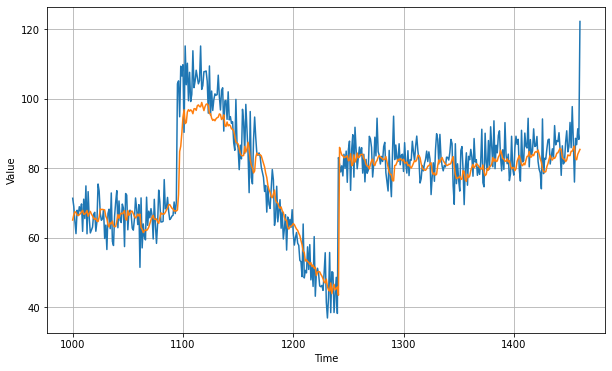

In [9]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [10]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.1165447

<Figure size 432x288 with 0 Axes>

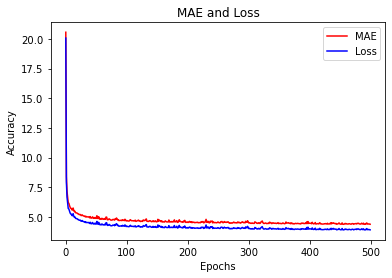

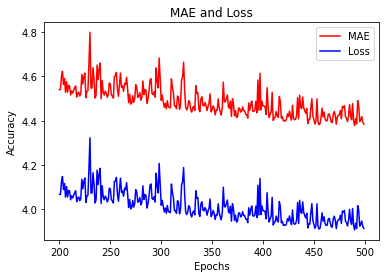

<Figure size 432x288 with 0 Axes>

In [11]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()